# Raytracing of modified DC telescopes with infinitesimal facets

#### Stephen Fegan
#### sfegan@llr.in2p3.fr
#### 2013-07-04

This notebook develops a semi-analytic ray tracing of the modified Davies-Cotton telescope design under the approximation of infinitesimal facet size. The general approach is that of Vassiliev, Fegan & Brousseau (Astroparticle Physics, 28, 10, 2007; hereafter VFB), section 2. The incoming rays are traced to the focal plane and the moments of the light distribution calculated by integration. Unlike VFB, the  integration is done numerically rather than by expansions. 

The more general Monte Carlo ray-tracing code, from which the majority of the results in this note have been derived, is validated against these results by running it in with as small a facet size as practical (1cm).

**Update 2016-07-13:** update for inclusion in *calin*

In [1]:
%pylab inline
matplotlib.rcParams['figure.figsize'] = 9, 6
from numpy import *
import scipy.integrate

Populating the interactive namespace from numpy and matplotlib


## Development of semi-analytic method

Following the methodology described in section 2 of Vassiliev, Fegan & Brousseau (Astroparticle Physics, 28, 10, 2007; hereafter VFB), we derive the tangential and sagittal PSF of an idealized modified Davies-Cotton reflector, with infinitesimal facet size. The reflector is a sphere with radius of curvature $R$ and aperture $D$. The surface is defined as:

\\[ \vec{r}(\phi,\theta) = R\\,\left(\begin{array}{c} \sin\theta\cos\phi \\\\ \sin\theta\sin\phi \\\\ 1-\cos\theta \end{array} \right\) \\]

where $\theta\in[0,\sin^{-1}(D/2R)]$ and $\phi\in[0,2\pi]$. 

To focus parallel on-axis rays (from infinity) to a point at $\vec{F}_0=(0,0,F)$ each facet must be aligned to a point on the z-axis the same distance from the focal point as is the facet,

\\[ \vec{A}(\phi,\theta)=\left(\begin{array}{c} 0 \\\\ 0 \\\\ F+|\vec{r}(\phi,\theta)-\vec{F}_0| \end{array}\right) = \left(\begin{array}{c} 0 \\\\ 0 \\\\ F+\sqrt{4R(R-F)\sin^2(\theta/2)+F^2} \end{array}\right) \\]

It can be seen that for the standard Davies-Cotton design (i.e. $R=F$), this simplifies to the usual value of $\vec{A}_{DC}=(0,0,2F)$. For the modified Davies-Cotton design, however, the alignment point is different for each ring of facets at a given value of $\theta$. When the facets are aligned, the normal for each facet is:

\\[ \vec{n}(\phi,\theta) = \frac{\vec{A}(\phi,\theta)-\vec{r}(\phi,\theta)}{|\vec{A}(\phi,\theta)-\vec{r}(\phi,\theta)|} \\]

We wish to image a source in a plane at distance $u$ from the central mirror, at the position,

\\[ \vec{u} = \left(\begin{array}{c} -u\tan\delta \\\\ 0 \\\\ -u \end{array}\right) \\]

onto an image plane at distance $v$ from the central mirror, given by the standard mirror formula:

\\[ \frac{1}{v} = \frac{1}{F} - \frac{1}{u} \\]

As in VFB, we define the direction of an incoming ray from infinity as,

\\[ \vec{g}(\phi,\theta) = \frac{\vec{r}(\phi,\theta)-\vec{u}}{|\vec{r}(\phi,\theta)-\vec{u}|} \\]

and the reflected ray therefore has direction,

\\[ \vec{s}(\phi,\theta) = \vec{g} - 2\left(\vec{g}\cdot\vec{n}(\phi,\theta)\right)\\,\vec{n}(\phi,\theta) \\]

The reflected ray crosses the focal plane at,

\\[ \vec{r}_{fp}(\phi,\theta) = v\\,\left(\begin{array}{c} x(\phi,\theta) \\\\ y(\phi,\theta) \\\\ 1 \end{array}\right) = \vec{r}(\phi,\theta) + t \vec{s}(\phi,\theta) \\]

The z-component can be solved to give $t$, and hence $(x,y)$. 

The total time of flight of the photon (assuming vacuum propagation) is:

\\[ T(\phi,\theta) = \frac{|\vec{r}(\phi,\theta) - \vec{u}|\\,+\\, |\vec{r}_{fp}(\phi,\theta)-\vec{r}(\phi,\theta)|}{c} \\]

The relevant moments of the light distribution on the image plane, i.e. the mean and variances in the tangential (x) and sagittal (y) directions ($\hat{x},\hat{y},\sigma^2_x,\sigma^2_y$), and the mean time of flight and its variance over the image plane ($\hat{T},\sigma^2_T$) can be calculate by integrating:

\\[ \mathcal{I}[f(\phi,\theta)] = R^2 \int_0^{\sin^{-1}(D/2R)} \int_0^{2\pi} f(\phi,\theta) \left|\vec{g}(\phi,\theta)\cdot\vec{n}(\phi,\theta)\right| \cos\theta\sin\theta d\theta d\phi \\]

where the term $\left|\vec{g}(\phi,\theta)\cdot\vec{n}(\phi,\theta)\right|$ accounts for inclination of the facet with respect to the rays and the $\cos\theta$ term accounts for the fact that the facet spacing is not defined by the spherical area element, but rather its projection onto a plane parallel to the optical axis. **Note: VFB did not include the dot product factor (as did Bretz and Ribordy, Astroparticle Physics, 45, 44, 2013), as they both assume a 100% reflecting telescope, which cannot be realized in the MC simulation.**

For example, the mean and variances in the tangential plane are:

\\[ \hat{x} = \frac{\mathcal{I}[x(\phi,\theta)]}{\mathcal{I}[1]}\ \ \textrm{and}\ \ \sigma^2_x = \frac{\mathcal{I}[x^2(\phi,\theta)]}{\mathcal{I}[1]} - \hat{x}^2 \\]

These integrals can be done by expansions (as in VFB) or numerically. Code to evaluate them numerically using the SciPy quadrature double integration routine is presented below.

In [2]:
# This code is not very efficient, it recalculates many quantities from many
# different functions. It is easy to maintain though, and does not need to be
# run very often.

def r(t,p,R,F): # Position on reflector of facet at theta,phi
    return R*array([sin(t)*cos(p), sin(t)*sin(p), 1-cos(t)])

def A(t,p,R,F): # Alignment point for facet at theta,phi
    return array([0,0,F+norm(r(t,p,R,F)-array([0,0,F]))])

def n(t,p,R,F): # Normal of facet at theta,phi
    _n = A(t,p,R,F)-r(t,p,R,F)
    return _n/norm(_n)

def g(t,p,U,R,F):
    _g = r(t,p,R,F)-U
    return _g/norm(_g)

def s(t,p,U,R,F): # Direction of ray reflected from facet at theta,phi
    _g = g(t,p,U,R,F)
    _n = n(t,p,R,F)
    return _g - 2*dot(_g,_n)*_n   
    
def r_im(t,p,U,R,F): # Position on image plane of ray reflected from facet at theta,phi
    V = 1.0/(1.0/F-1.0/U[2])
    _r = r(t,p,R,F)
    _s = s(t,p,U,R,F)
    tim = (V-_r[2])/_s[2]
    return (_r+tim*_s)/V

def integrate(fn,U,R,F,D): # Integral of parallel beam over full reflector
    integrand = lambda t,p: -(R**2)*sin(t)*fn(t,p)*cos(t)*dot(n(t,p,R,F),g(t,p,U,R,F))
    tmax = arcsin(D/2.0/R)
    gfun = lambda p: 0
    hfun = lambda p: tmax
    return scipy.integrate.dblquad(integrand,0,2*pi,gfun,hfun)

### Illustration of focal plane images

To test the code we attempt to qualitatively reproduce the "reentrant double (cometary) ring" structures described by Lewes (Experimental Astronomy, 1, 213, 1990) using the parameters of the modified Davies-Cotton design of the MST. The plot below shows the focal plane image formed by the rays reflected from the ring of facets at 2m, 4m and 6m from the center of the reflector for incoming rays at angles between $0^\circ$ and $4^\circ$.

In [3]:
F = 1600.
R = F*1.2
D = 1200.
Uz = 10.6 * 1e5

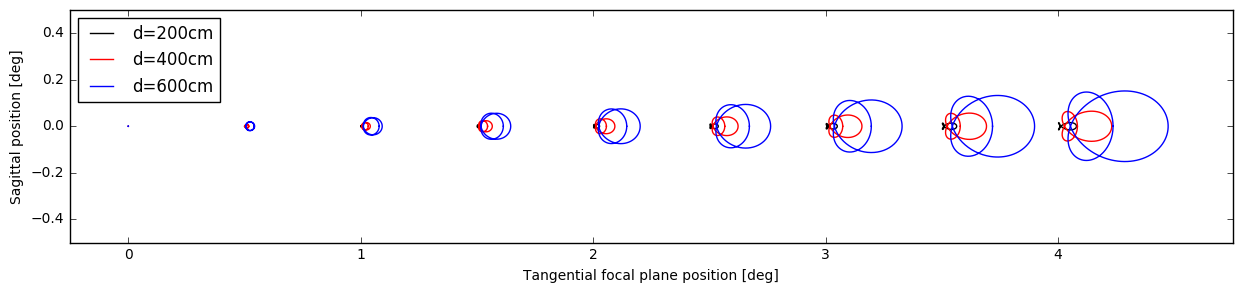

In [4]:
d = 4.0/180.0*pi

figure(1,figsize=[15,3])
labset=False
C = [ 'k','r','b' ]
for d in arange(0,4.01,0.5)/180.0*pi:
    U = array([-Uz*tan(d), 0, Uz])
    for i in range(0,3):
        Di = D*float(i+1)/3.0/2.0
        t = Di/R
        p = arange(0.0,360.1,1)/180.0*pi
        rfp = list(map(lambda _p: r_im(t,_p,U,R,F),p))
        x = array(list(map(lambda _r: _r[0]/pi*180, rfp)))
        y = array(list(map(lambda _r: _r[1]/pi*180, rfp)))
        lab = "_NOLABEL_"
        if labset==False:
            lab = 'd=%.0fcm'%Di
        plot(x,y,C[i],label=lab)
    labset = True
axis([-0.25, 4.75, -.5, .5]);
xlabel('Tangential focal plane position [deg]')
ylabel('Sagittal position [deg]')
legend(loc=2);
#gcf().savefig('zfs_lewes_10k.pdf',bbox_inches='tight')

## Image moments using semi-analytic method

In [5]:
def tof(t,p,U,R,F):
    V = 1.0/(1.0/F-1.0/U[2])
    r_ref = r(t,p,R,F)
    return (norm(r_ref-U)+norm(r_im(t,p,U,R,F)*V - r_ref))/2.9979246e+10

def calcPSF_SA(dv, R, F, D, Uz):
    meanxv = []
    meanyv = []
    meantv = []
    rmsxv = []
    rmsyv = []
    rmstv = []
    
    for d in dv:
        U = array([-Uz*tan(d), 0, Uz])
        
        int1  = integrate(lambda t,p: 1,U,R,F,D)
        intx  = integrate(lambda t,p: r_im(t,p,U,R,F)[0],U,R,F,D)
        inty  = integrate(lambda t,p: r_im(t,p,U,R,F)[1],U,R,F,D)
        intxx = integrate(lambda t,p: r_im(t,p,U,R,F)[0]**2,U,R,F,D)
        intyy = integrate(lambda t,p: r_im(t,p,U,R,F)[1]**2,U,R,F,D)
        intt  = integrate(lambda t,p: tof(t,p,U,R,F),U,R,F,D)
        inttt = integrate(lambda t,p: tof(t,p,U,R,F)**2,U,R,F,D)

        meanx = intx[0]/int1[0]
        meany = inty[0]/int1[0]
        meant = intt[0]/int1[0]

        varx = intxx[0]/int1[0] - meanx**2
        vary = intyy[0]/int1[0] - meany**2
        vart = inttt[0]/int1[0] - meant**2

        meanxv.append(meanx)
        meanyv.append(meany)
        meantv.append(meant)
        rmsxv.append(sqrt(varx))
        rmsyv.append(sqrt(vary))
        rmstv.append(sqrt(vart))
    
    meanx = array(meanxv)
    meany = array(meanyv)
    meant = array(meantv)
    rmsx = array(rmsxv)
    rmsy = array(rmsyv)
    rmst = array(rmstv)
    
    return meanx, meany, rmsx, rmsy, meant, rmst

In [6]:
dv = arange(0.0,10.01,0.1)/180.0*pi
meanx_sa, meany_sa, rmsx_sa, rmsy_sa, meant_sa, rmst_sa = calcPSF_SA(dv,R,F,D,Uz)

Fitting a linear function to the centroid position gives the plate-scale correction factor appropriate for this modified DC design:

In [7]:
P=polyfit(dv,meanx_sa,1)
print("Plate-scale factor: %.3f"%P[0])

Plate-scale factor: 1.035


## Image moments using Monte Carlo ray-tracing code

The Monte Carlo ray-tracing code cannot simulate the zero-facet-size case exactly, instead a 1cm facet size is used, giving a telescope with 1.3 million facets.

In [8]:
import sys,os
from calin.simulation.vs_optics import *
from numpy import *

In [9]:
def calcPSF_RT(dv, R, F, D, Uz, N=100000):
    param = calin.ix.simulation.vs_optics.IsotropicDCArrayParameters()
    param.mutable_prescribed_array_layout().add_scope_positions();
    dc = param.mutable_reflector()
    dc.set_curvature_radius(R)
    dc.set_aperture(D)
    dc.set_facet_spacing(1.0)
    dc.set_facet_size(dc.facet_spacing())
    dc.set_facet_focal_length(F)
    dc.mutable_psf_align().set_object_plane(inf);
    dc.set_alignment_image_plane(F)
    dc.set_weathering_factor(1.0)
    dc.set_facet_spot_size_probability(0.8)
    dc.set_facet_spot_size(0)
    param.mutable_focal_plane().mutable_translation().set_y(1.0/(1.0/F-1.0/Uz))
    param.mutable_pixel().set_spacing(1)
    param.mutable_pixel().set_cone_inner_diameter(1)
    param.mutable_pixel().set_cone_survival_prob(1)

    rng = calin.math.rng.RNG()
    cta = calin.simulation.vs_optics.VSOArray()
    cta.generateFromArrayParameters(param, rng)
    scope = cta.telescope(0)
    
    print(scope.numMirrors(), scope.numPixels())
    
    PS = 1/scope.focalPlanePosition()[1]

    raytracer = calin.simulation.vs_optics.VSORayTracer(cta, rng)
    ph = calin.math.ray.Ray()
    info = calin.simulation.vs_optics.VSOTraceInfo()

    nhit = []
    meanxv = []
    meanyv = []
    meantv = []
    rmsxv = []
    rmsyv = []
    rmstv = []
    for d in dv:
        x = []
        y = []
        t = []
        for i in range(0,N):
            raytracer.testBeam(ph, scope, d, 0, Uz)
            pixel = raytracer.trace(ph, info, scope)
#            print(info.status)
            if info.rayHitFocalPlane():
                x.append(info.fplane_z)
                y.append(info.fplane_x)
                t.append(info.fplane_t)
        x = array(x)*PS
        y = array(y)*PS
        nhit.append(len(x))
        meanxv.append(mean(x))
        meanyv.append(mean(y))
        meantv.append(mean(t))
        rmsxv.append(std(x))
        rmsyv.append(std(y))
        rmstv.append(std(t))

    nhit  = array(nhit)
    meanx = array(meanxv)
    meany = array(meanyv)
    meant = array(meantv)
    rmsx  = array(rmsxv)
    rmsy  = array(rmsyv)
    rmst  = array(rmstv)
    
    return nhit, meanx, meany, rmsx, rmsy, meant, rmst

In [10]:
dv2 = arange(0.0,10.01,0.5)/180.0*pi
nhit_rt, meanx_rt, meany_rt, rmsx_rt, rmsy_rt, meant_rt, rmst_rt = calcPSF_RT(dv2,R,F,D,Uz,N=100000)

1305787 1


## Comparison of results - PSF and time dispersion

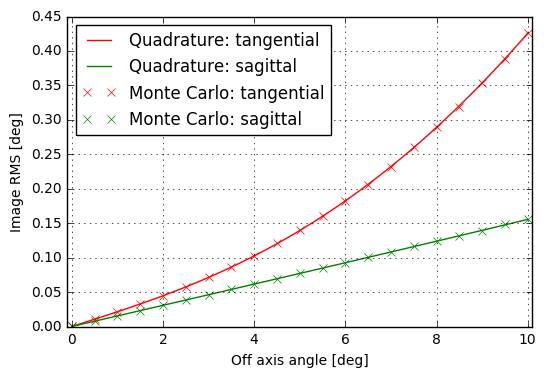

In [11]:
figure(figsize=(6,4))
plot(dv/pi*180,rmsx_sa/pi*180,'r-',label='Quadrature: tangential')
plot(dv/pi*180,rmsy_sa/pi*180,'g-',label='Quadrature: sagittal')
plot(dv2/pi*180,rmsx_rt/pi*180,'rx',label='Monte Carlo: tangential')
plot(dv2/pi*180,rmsy_rt/pi*180,'gx',label='Monte Carlo: sagittal')
xlabel('Off axis angle [deg]')
ylabel('Image RMS [deg]')
legend(loc=2)
axis(array(axis())+array([-0.1, 0.1, 0, 0]))
grid()
#gcf().savefig('zfs_rms_10k.pdf',bbox_inches='tight')

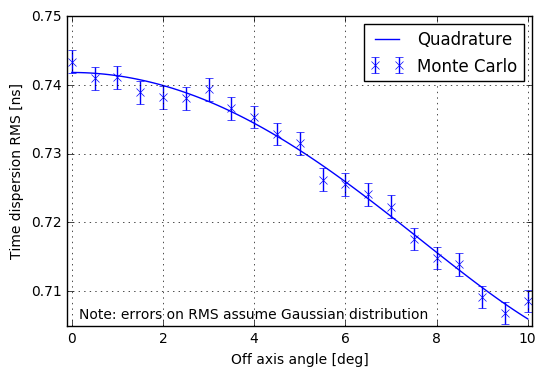

In [12]:
figure(figsize=(6,4))
plot(dv/pi*180,rmst_sa*1e9,'b-',label='Quadrature')
#plot(dv2/pi*180,rmst_rt*1e9,'bx',label='Monte Carlo')
errorbar(dv2/pi*180,rmst_rt*1e9,fmt='bx',yerr=rmst_rt*1e9/sqrt(2*nhit_rt),label='Monte Carlo')
text(0.025,0.025,'Note: errors on RMS assume Gaussian distribution',transform=gca().transAxes)
xlabel('Off axis angle [deg]')
ylabel('Time dispersion RMS [ns]')
legend(loc=1)
a=array(axis())
a[0] = -0.1
a[1] = 10.1
a[3] = 0.7501
axis(a)
grid()
#gcf().savefig('zfs_tdisp_10k.pdf',bbox_inches='tight')

## System with f=F/D=1600/2400=0.67

A more challenging comparison can be made to a faster optical system, with double the aperture (i.e. $f=0.67$). Here the angles between the mirrors and the beam are much more pronounced and it might be expected that any differences between the codes would be more clearly visible. The MC simulation has 5.2 million 1cm facets.

In [13]:
meanx_sa_x2, meany_sa_x2, rmsx_sa_x2, rmsy_sa_x2, meant_sa_x2, rmst_sa_x2 = calcPSF_SA(dv,R,F,D*2.0,Uz)
nhit_rt_x2, meanx_rt_x2, meany_rt_x2, rmsx_rt_x2, rmsy_rt_x2, meant_rt_x2, rmst_rt_x2 = calcPSF_RT(dv2,R,F,D*2.0,Uz,N=100000)

5223583 1


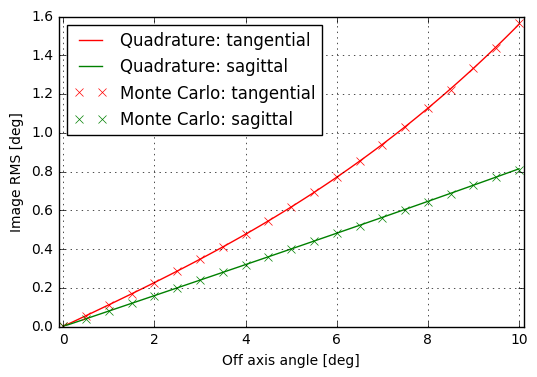

In [14]:
figure(figsize=(6,4))
plot(dv/pi*180,rmsx_sa_x2/pi*180,'r-',label='Quadrature: tangential')
plot(dv/pi*180,rmsy_sa_x2/pi*180,'g-',label='Quadrature: sagittal')
plot(dv2/pi*180,rmsx_rt_x2/pi*180,'rx',label='Monte Carlo: tangential')
plot(dv2/pi*180,rmsy_rt_x2/pi*180,'gx',label='Monte Carlo: sagittal')
xlabel('Off axis angle [deg]')
ylabel('Image RMS [deg]')
legend(loc=2)
axis(array(axis())+array([-0.1, 0.1, 0, 0]))
grid()
#gcf().savefig('zfs_rms_D2400_10k.pdf',bbox_inches='tight')

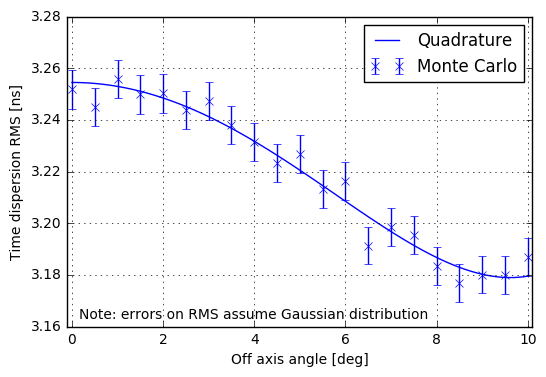

In [15]:
figure(figsize=(6,4))
plot(dv/pi*180,rmst_sa_x2*1e9,'b-',label='Quadrature')
#plot(dv2/pi*180,rmst_rt_x2*1e9,'bx',label='Monte Carlo')
errorbar(dv2/pi*180,rmst_rt_x2*1e9,fmt='bx',yerr=rmst_rt_x2*1e9/sqrt(2*nhit_rt_x2),label='Monte Carlo')
text(0.025,0.025,'Note: errors on RMS assume Gaussian distribution',transform=gca().transAxes)
xlabel('Off axis angle [deg]')
ylabel('Time dispersion RMS [ns]')
legend(loc=1)
a=array(axis())
a[0] = -0.1
a[1] = 10.1
axis(a)
grid()
#gcf().savefig('zfs_tdisp_D2400_10k.pdf',bbox_inches='tight')

In [16]:
#numpy.savez('zfs_10k.npz',dv, meanx_sa, meany_sa, rmsx_sa, rmsy_sa, meant_sa, rmst_sa,
#    dv2, nhit_rt, meanx_rt, meany_rt, rmsx_rt, rmsy_rt, meant_rt, rmst_rt,
#    meanx_sa_x2, meany_sa_x2, rmsx_sa_x2, rmsy_sa_x2, meant_sa_x2, rmst_sa_x2,
#    nhit_rt_x2, meanx_rt_x2, meany_rt_x2, rmsx_rt_x2, rmsy_rt_x2, meant_rt_x2, rmst_rt_x2)

## Conclusions

The agreement between the semi-analytic and full code is very good over a wide range of off-axis angle, and serves to validate the full ray-tracing code, at least with respect to its handling of the overall reflector structure.